In [23]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.onnx
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
import torchvision.transforms as T

In [24]:
# -------------------------
# CONFIGURATION
# -------------------------
IMG_SIZE = 310
BATCH_SIZE = 16
EPOCHS = 50
LR = 1e-4

BASE_PATH = "/kaggle/input/milan-eraser/"
CSV_PATH = os.path.join(BASE_PATH, "annotations_binary.csv")
DATA_DIR = os.path.join(BASE_PATH, "arrays/arrays")
if not os.path.exists(DATA_DIR):
    DATA_DIR = os.path.join(BASE_PATH, "arrays")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [25]:
# -------------------------
# REPRODUCIBILITY
# -------------------------
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(42)
print("Seed set for reproducibility.")

Seed set for reproducibility.


In [26]:
# -------------------------
# LOAD CSV
# -------------------------
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

if "error" in df.columns:
    df.rename(columns={"error": "defect"}, inplace=True)
if "ID" in df.columns:
    df.rename(columns={"ID": "file_prefix"}, inplace=True)

df["file_prefix"] = df["file_prefix"].astype(str).str.strip()
df["label"] = df["defect"].astype(int)

/tmp/ipykernel_55/668561171.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df["label"], palette=["skyblue", "salmon"])


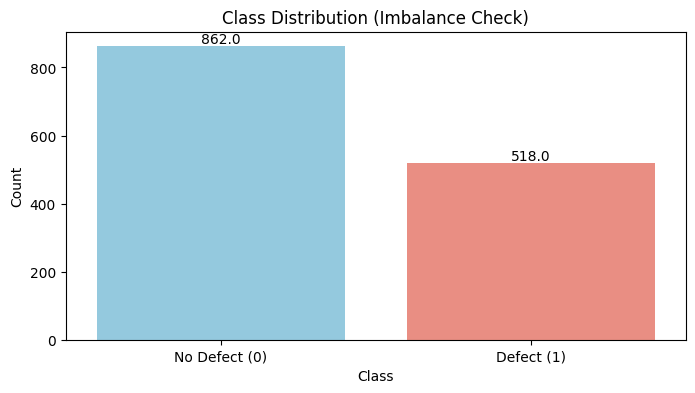

In [27]:
# -------------------------
# CLASS DISTRIBUTION
# -------------------------
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=df["label"], palette=["skyblue", "salmon"])
plt.title("Class Distribution (Imbalance Check)")
plt.xticks([0, 1], ["No Defect (0)", "Defect (1)"])
plt.xlabel("Class")
plt.ylabel("Count")
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.show()

Visualizing a Defective Sample:


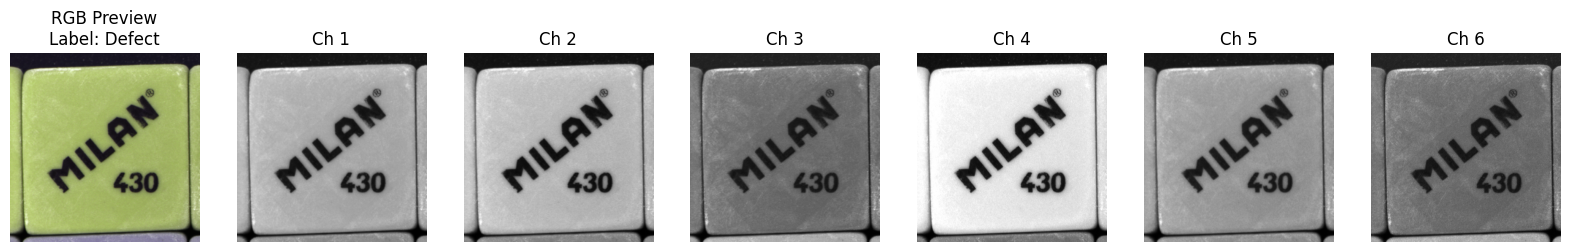

In [28]:
# -------------------------
# VISUALIZE 6-CHANNEL SAMPLE
# -------------------------
def visualize_npy_sample(file_prefix, label):
    path = os.path.join(DATA_DIR, f"{file_prefix}.npy")
    try:
        data = np.load(path).astype(np.float32)

        if data.max() > 1.0:
            data = data / 255.0

        if data.ndim == 3 and data.shape[0] == 6:
            data = np.transpose(data, (1, 2, 0))

        fig, axes = plt.subplots(1, 7, figsize=(20, 3))

        axes[0].imshow(data[:, :, :3])
        axes[0].set_title(f"RGB Preview\nLabel: {label}")
        axes[0].axis("off")

        for i in range(6):
            axes[i + 1].imshow(data[:, :, i], cmap="gray")
            axes[i + 1].set_title(f"Ch {i+1}")
            axes[i + 1].axis("off")

        plt.show()
    except Exception as e:
        print(f"Error loading {path}: {e}")


defect_sample = df[df["label"] == 1].iloc[0]
print("Visualizing a Defective Sample:")
visualize_npy_sample(defect_sample["file_prefix"], "Defect")

In [29]:
# -------------------------
# TRANSFORMS (AUGMENT TRAIN ONLY)
# -------------------------
def apply_transform_to_6_channels_fixed(arr, img_size=IMG_SIZE):
    if arr.shape[0] != 6:
        arr = np.transpose(arr, (2, 0, 1))
    img_tensor = torch.from_numpy(arr.astype(np.float32))
    transforms = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomRotation(degrees=15),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15)),
    ])
    img_tensor = transforms(img_tensor)
    return img_tensor


def apply_transform_val_fixed(arr, img_size=IMG_SIZE):
    if arr.shape[0] != 6:
        arr = np.transpose(arr, (2, 0, 1))
    img_tensor = torch.from_numpy(arr.astype(np.float32))
    transforms = T.Compose([
        T.Resize((img_size, img_size)),
    ])
    img_tensor = transforms(img_tensor)
    return img_tensor

In [30]:
# -------------------------
# DATASET (AUGMENT TRAIN ONLY)
# -------------------------
class NpyDataset(Dataset):
    def __init__(self, df, data_dir, is_train=False, img_size=IMG_SIZE):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.is_train = is_train
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_prefix = str(row["file_prefix"]).strip()
        file_path = os.path.join(self.data_dir, f"{file_prefix}.npy")

        arr = np.load(file_path).astype(np.float32)

        if self.is_train:
            x = apply_transform_to_6_channels_fixed(arr, img_size=self.img_size)
        else:
            x = apply_transform_val_fixed(arr, img_size=self.img_size)

        if x.max() > 1.0:
            x = x / 255.0

        y = torch.tensor([row["label"]], dtype=torch.float32)
        return x, y

In [31]:
# -------------------------
# TRAIN/VAL SPLIT
# -------------------------
train_df, val_df = train_test_split(
    df[["file_prefix", "label"]].rename(columns={"label": "defect"}),
    test_size=0.20,
    random_state=42,
    stratify=df["label"]
)

train_df = train_df.rename(columns={"defect": "label"}).reset_index(drop=True)
val_df = val_df.rename(columns={"defect": "label"}).reset_index(drop=True)

print(f"Train Size: {len(train_df)}")
print(f"Val Size:   {len(val_df)}")
print(f"Val Positives (Defects): {int(val_df['label'].sum())}")

Train Size: 1104
Val Size:   276
Val Positives (Defects): 104


In [32]:
# -------------------------
# POS WEIGHT (IMBALANCE)
# -------------------------
num_pos = float(train_df["label"].sum())
num_neg = float(len(train_df) - num_pos)
pos_weight_val = (num_neg / num_pos) if num_pos > 0 else 1.0
print(f"Calculated pos_weight: {pos_weight_val:.4f}")

Calculated pos_weight: 1.6667


In [34]:
# -------------------------
# DATASETS
# -------------------------
train_ds = NpyDataset(train_df, DATA_DIR, is_train=True, img_size=IMG_SIZE)
val_ds = NpyDataset(val_df, DATA_DIR, is_train=False, img_size=IMG_SIZE)

In [35]:
# -------------------------
# WEIGHTED SAMPLER (IMBALANCE)
# -------------------------
labels_np = train_df["label"].values.astype(int)
class_counts = np.bincount(labels_np, minlength=2)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[labels_np].astype(np.float32)

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights),
    num_samples=len(train_ds),
    replacement=True
)

In [36]:
# -------------------------
# DATALOADERS
# -------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

In [37]:
# -------------------------
# MODEL: RESNET50 (6-CHANNEL)
# -------------------------
def build_resnet50_6ch(device=DEVICE, dropout_p=0.6):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # Replace first conv layer to accept 6 channels
    old_conv = model.conv1
    new_conv = nn.Conv2d(
        in_channels=6,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False,
    )

    # Initialize weights: duplicate pretrained RGB weights
    with torch.no_grad():
        new_conv.weight[:, :3, :, :] = old_conv.weight
        new_conv.weight[:, 3:6, :, :] = old_conv.weight

    model.conv1 = new_conv

    # Replace final FC layer for binary classification
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 1)

    return model.to(device)


# Use ResNet50 now
model = build_resnet50_6ch(device=DEVICE)
print(f"Model initialized: ResNet50 6-channel | Input: {IMG_SIZE}x{IMG_SIZE}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s] 


Model initialized: ResNet50 6-channel | Input: 310x310


In [38]:
# -------------------------
# LOSS + OPTIMIZER + SCHEDULER
# -------------------------
pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.1, patience=10
)

In [39]:
# -------------------------
# METRICS
# -------------------------
def calculate_metrics(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs > threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc_pr = average_precision_score(y_true, y_probs)
    except Exception:
        auc_pr = 0.0
    return acc, f1, auc_pr

In [40]:
def run_epoch_metrics(loader, model, criterion, is_training, optimizer=None):
    model.train() if is_training else model.eval()

    running_loss = 0.0
    all_lbls = []
    all_probs = []

    for inputs, labels in loader:
        inputs = inputs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True).squeeze(1)

        if is_training:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_training):
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            if is_training:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

        running_loss += loss.item()
        all_lbls.extend(labels.detach().cpu().numpy())
        all_probs.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    avg_loss = running_loss / len(loader)
    acc, f1, auc_pr = calculate_metrics(np.array(all_lbls), np.array(all_probs))
    return avg_loss, acc, f1, auc_pr

In [41]:
# -------------------------
# TRAINING LOOP
# -------------------------
best_auc = 0.0
history = {
    "train_loss": [], "val_loss": [],
    "train_auc": [],  "val_auc": [],
    "train_f1": [],   "val_f1": [],
}

print("\nTRAINING: BCEWithLogitsLoss ONLY | Epochs=50 | WeightedSampler | RandomAffine")
for epoch in range(EPOCHS):
    t_loss, t_acc, t_f1, t_auc = run_epoch_metrics(
        train_loader, model, criterion, is_training=True, optimizer=optimizer
    )
    v_loss, v_acc, v_f1, v_auc = run_epoch_metrics(
        val_loader, model, criterion, is_training=False, optimizer=None
    )

    history["train_loss"].append(t_loss)
    history["val_loss"].append(v_loss)
    history["train_auc"].append(t_auc)
    history["val_auc"].append(v_auc)
    history["train_f1"].append(t_f1)
    history["val_f1"].append(v_f1)

    scheduler.step(v_auc)

    print(
        f"Ep {epoch+1} | "
        f"T_Loss:{t_loss:.3f} T_Acc:{t_acc:.3f} T_F1:{t_f1:.3f} T_AUC:{t_auc:.3f} | "
        f"V_Loss:{v_loss:.3f} V_Acc:{v_acc:.3f} V_F1:{v_f1:.3f} V_AUC:{v_auc:.3f}"
    )

    if v_auc > best_auc:
        best_auc = v_auc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  -> Saved Best Model (Val AUC-PR improved to {best_auc:.4f})")



TRAINING: BCEWithLogitsLoss ONLY | Epochs=50 | WeightedSampler | RandomAffine
Ep 1 | T_Loss:0.893 T_Acc:0.521 T_F1:0.633 T_AUC:0.542 | V_Loss:0.821 V_Acc:0.514 V_F1:0.589 V_AUC:0.568
  -> Saved Best Model (Val AUC-PR improved to 0.5677)
Ep 2 | T_Loss:0.872 T_Acc:0.532 T_F1:0.612 T_AUC:0.620 | V_Loss:0.772 V_Acc:0.692 V_F1:0.564 V_AUC:0.641
  -> Saved Best Model (Val AUC-PR improved to 0.6408)
Ep 3 | T_Loss:0.818 T_Acc:0.605 T_F1:0.670 T_AUC:0.690 | V_Loss:0.786 V_Acc:0.667 V_F1:0.521 V_AUC:0.598
Ep 4 | T_Loss:0.814 T_Acc:0.622 T_F1:0.673 T_AUC:0.696 | V_Loss:0.939 V_Acc:0.500 V_F1:0.592 V_AUC:0.759
  -> Saved Best Model (Val AUC-PR improved to 0.7591)
Ep 5 | T_Loss:0.796 T_Acc:0.619 T_F1:0.679 T_AUC:0.739 | V_Loss:0.687 V_Acc:0.688 V_F1:0.664 V_AUC:0.754
Ep 6 | T_Loss:0.758 T_Acc:0.692 T_F1:0.695 T_AUC:0.759 | V_Loss:0.596 V_Acc:0.754 V_F1:0.694 V_AUC:0.821
  -> Saved Best Model (Val AUC-PR improved to 0.8209)
Ep 7 | T_Loss:0.745 T_Acc:0.683 T_F1:0.710 T_AUC:0.785 | V_Loss:0.664 V_Acc

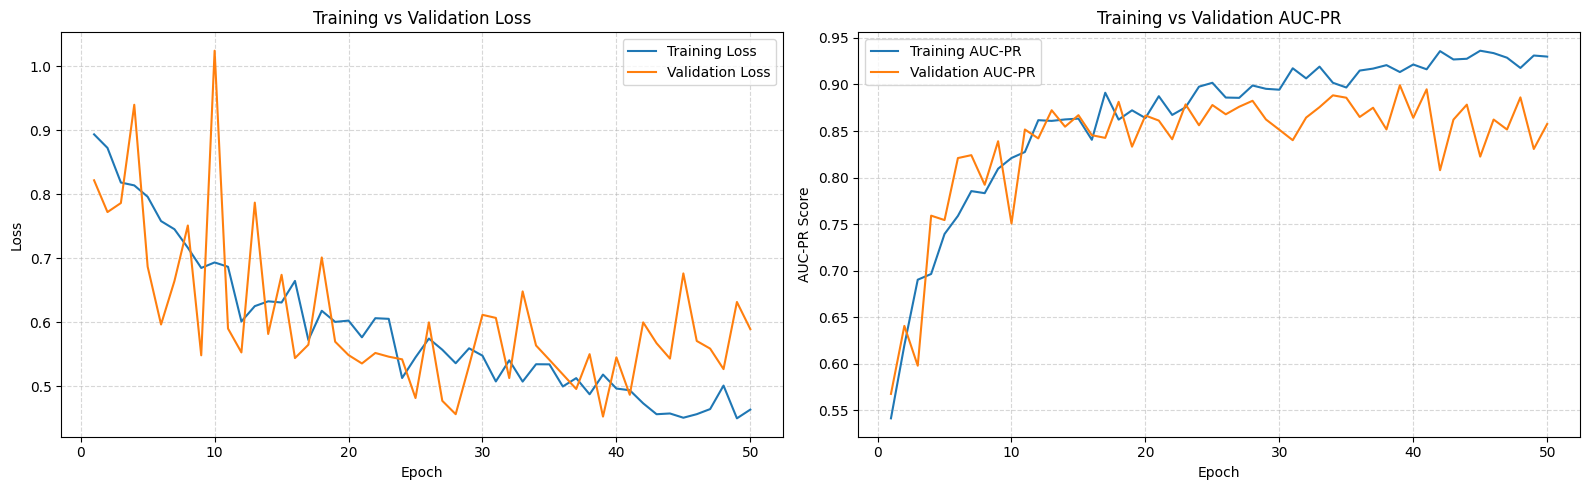

In [42]:
# -------------------------
# PLOT HISTORY
# -------------------------
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Training Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_auc"], label="Training AUC-PR")
plt.plot(epochs, history["val_auc"], label="Validation AUC-PR")
plt.title("Training vs Validation AUC-PR")
plt.xlabel("Epoch")
plt.ylabel("AUC-PR Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()




FINAL VALIDATION REPORT (NO TTA)
Optimal Threshold: 0.6643

Validation AUC-PR: 0.8992
Validation F1:     0.8137

Classification Report (Validation):
              precision    recall  f1-score   support

   No Defect       0.88      0.90      0.89       172
      Defect       0.83      0.80      0.81       104

    accuracy                           0.86       276
   macro avg       0.86      0.85      0.85       276
weighted avg       0.86      0.86      0.86       276



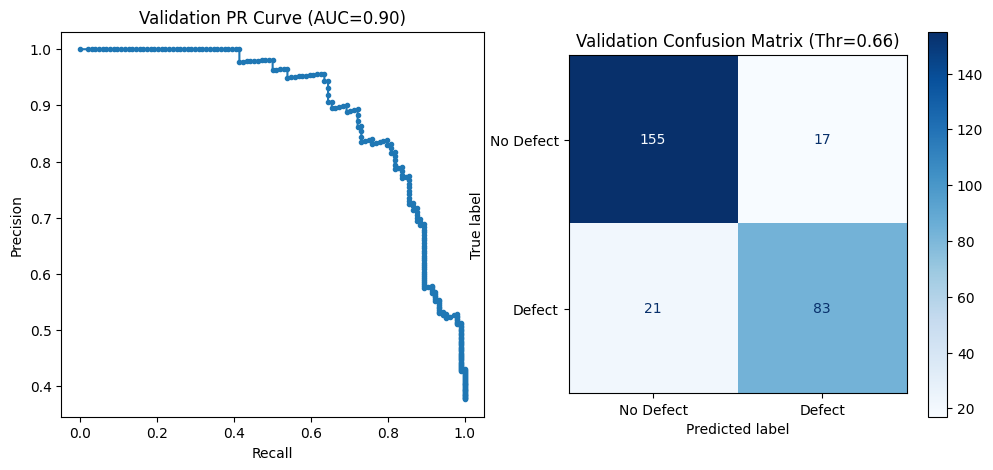

In [43]:
# -------------------------
# FINAL VALIDATION REPORT (NO TTA)
# -------------------------
print("\nFINAL VALIDATION REPORT (NO TTA)")

model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

val_labels = []
val_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE, non_blocking=True)
        probs = torch.sigmoid(model(inputs).squeeze(1)).cpu().numpy()
        val_labels.extend(labels.squeeze(1).numpy())
        val_probs.extend(probs)

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thr = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5
print(f"Optimal Threshold: {best_thr:.4f}")

y_true = np.array(val_labels)
y_scores = np.array(val_probs)
y_pred = (y_scores > best_thr).astype(int)

final_auc = average_precision_score(y_true, y_scores)
final_f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"\nValidation AUC-PR: {final_auc:.4f}")
print(f"Validation F1:     {final_f1:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_true, y_pred, target_names=["No Defect", "Defect"]))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker=".")
plt.title(f"Validation PR Curve (AUC={final_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.subplot(1, 2, 2)
ConfusionMatrixDisplay(
    confusion_matrix(y_true, y_pred),
    display_labels=["No Defect", "Defect"],
).plot(ax=plt.gca(), cmap="Blues")
plt.title(f"Validation Confusion Matrix (Thr={best_thr:.2f})")
plt.show()

In [44]:
# -------------------------
# EXPORT BEST MODEL TO ONNX (310x310)
# -------------------------
print("Exporting best model to ONNX...")

model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

dummy_input = torch.randn(1, 6, IMG_SIZE, IMG_SIZE).to(DEVICE)
onnx_path = "r50.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=False,
    input_names=["input"],
    output_names=["output"],
    export_params=True,
    opset_version=12
)

print(f"SUCCESS: Model saved to {onnx_path}")

Exporting best model to ONNX...


/tmp/ipykernel_55/3907501887.py:12: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


SUCCESS: Model saved to r50.onnx
